In [2]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(momentum_buffer, alpha=-group['lr']) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss

class SqrtLRScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, base_lr, batch_size, warmup_epochs, total_epochs, reference_batch_size, verbose=False):
        """
        Args:
            optimizer: PyTorch optimizer (e.g., Adam, LAMB, LARS).
            base_lr: Base learning rate for the reference batch size.
            batch_size: Current batch size.
            warmup_epochs: Number of warmup epochs.
            total_epochs: Total number of epochs.
            reference_batch_size: Batch size for which the base_lr is defined.
            verbose: Whether to print LR updates.
        """
        self.base_lr = base_lr
        self.batch_size = batch_size
        self.scaled_lr = base_lr * (batch_size / reference_batch_size) ** 0.5
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.verbose = verbose
        super(SqrtLRScheduler, self).__init__(optimizer)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            # Linear warmup scaling
            warmup_factor = (epoch + 1) / self.warmup_epochs
            return [warmup_factor * self.scaled_lr for _ in self.optimizer.param_groups]
        else:
            # polynomially decaying learning rate of ηt = η0×(1−t/T)
            if epoch == self.warmup_epochs:
                print(f"Warmup phase completed at epoch {epoch}. Switching to constant learning rate.")
            return [self.scaled_lr * ( 1 - ( (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs))) for _ in self.optimizer.param_groups]

# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 5e-1
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# scheduler should be e square root LR scaling rule and linear-epoch warmup scheduling to automatically adjust learning rate
scheduler = SqrtLRScheduler(
    optimizer = optimizer,
    base_lr = base_lr,
    batch_size = args.batch_size,
    warmup_epochs = args.warmup_epochs,
    total_epochs = args.epochs,
    reference_batch_size = reference_batch_size,
    verbose = True)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader , testloader, device, epochs, save_checkpoint_interval=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        scheduler.step()

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Test Loss: {test_loss:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, test_loss, train_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Overwriting large_batch_training.py


100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
--- Train with SGDM ---
Epoch 1/150, Train Acc: 2.05%, Test Acc: 3.08%
Epoch 1/150, Train Loss: 4.5870,  Test Loss: 4.5042
Epoch 2/150, Train Acc: 6.71%, Test Acc: 10.06%
Epoch 2/150, Train Loss: 4.1271,  Test Loss: 3.8815
Epoch 3/150, Train Acc: 12.00%, Test Acc: 16.24%
Epoch 3/150, Train Loss: 3.7700,  Test Loss: 3.5460
Epoch 4/150, Train Acc: 16.32%, Test Acc: 20.87%
Epoch 4/150, Train Loss: 3.4865,  Test Loss: 3.2534
Warmup phase completed at epoch 5. Switching to constant learning rate.
Epoch 5/150, Train Acc: 20.26%, Test Acc: 22.97%
Epoch 5/150, Train Loss: 3.2584,  Test Loss: 3.1651
Epoch 6/150, Train Acc: 24.50%, Test Acc: 26.99%
Epoch 6/150, Train Loss: 3.0299,  Test Loss: 2.9076
Epoch 7/150, Train Acc: 27.87%, Test Acc: 31.76%
Epoch 7/150, Train Loss: 2.8452,  Test Loss: 2.6597
Epoch 8/150, Train Acc: 31.11%, Test Acc: 34.62%
Epoch 8/150, Train Loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 35.39%, Test Acc: 36.42%
Epoch 10/150, Train Loss: 2.4957,  Test Loss: 2.4527
Epoch 11/150, Train Acc: 36.99%, Test Acc: 39.35%
Epoch 11/150, Train Loss: 2.4152,  Test Loss: 2.3442
Epoch 12/150, Train Acc: 38.56%, Test Acc: 39.21%
Epoch 12/150, Train Loss: 2.3451,  Test Loss: 2.3382
Epoch 13/150, Train Acc: 39.90%, Test Acc: 39.76%
Epoch 13/150, Train Loss: 2.2734,  Test Loss: 2.3254
Epoch 14/150, Train Acc: 41.33%, Test Acc: 40.30%
Epoch 14/150, Train Loss: 2.2251,  Test Loss: 2.2924
Epoch 15/150, Train Acc: 42.44%, Test Acc: 42.29%
Epoch 15/150, Train Loss: 2.1649,  Test Loss: 2.2060
Epoch 16/150, Train Acc: 43.73%, Test Acc: 42.61%
Epoch 16/150, Train Loss: 2.1151,  Test Loss: 2.2067
Epoch 17/150, Train Acc: 44.60%, Test Acc: 41.82%
Epoch 17/150, Train Loss: 2.0736,  Test Loss: 2.2494
Epoch 18/150, Train Acc: 45.15%, Test Acc: 43.92%
Epoch 18/150, Train Loss: 2.0413,  Test Loss: 2.1577
Epoch 19/150, Train Acc: 46.24%, Test Acc: 45.37%
Epoch 19/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 47.31%, Test Acc: 45.40%
Epoch 20/150, Train Loss: 1.9577,  Test Loss: 2.0751
Epoch 21/150, Train Acc: 47.88%, Test Acc: 45.87%
Epoch 21/150, Train Loss: 1.9210,  Test Loss: 2.0677
Epoch 22/150, Train Acc: 48.76%, Test Acc: 46.18%
Epoch 22/150, Train Loss: 1.8936,  Test Loss: 2.0739
Epoch 23/150, Train Acc: 49.22%, Test Acc: 46.77%
Epoch 23/150, Train Loss: 1.8659,  Test Loss: 2.0185
Epoch 24/150, Train Acc: 50.16%, Test Acc: 46.03%
Epoch 24/150, Train Loss: 1.8298,  Test Loss: 2.0471
Epoch 25/150, Train Acc: 50.49%, Test Acc: 47.26%
Epoch 25/150, Train Loss: 1.8050,  Test Loss: 2.0243
Epoch 26/150, Train Acc: 51.33%, Test Acc: 45.55%
Epoch 26/150, Train Loss: 1.7851,  Test Loss: 2.1183
Epoch 27/150, Train Acc: 51.53%, Test Acc: 47.86%
Epoch 27/150, Train Loss: 1.7565,  Test Loss: 2.0038
Epoch 28/150, Train Acc: 52.16%, Test Acc: 48.01%
Epoch 28/150, Train Loss: 1.7306,  Test Loss: 1.9848
Epoch 29/150, Train Acc: 52.85%, Test Acc: 47.57%
Epoch 29/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 53.31%, Test Acc: 48.07%
Epoch 30/150, Train Loss: 1.6913,  Test Loss: 2.0050
Epoch 31/150, Train Acc: 53.72%, Test Acc: 48.26%
Epoch 31/150, Train Loss: 1.6659,  Test Loss: 1.9835
Epoch 32/150, Train Acc: 53.90%, Test Acc: 49.74%
Epoch 32/150, Train Loss: 1.6534,  Test Loss: 1.9421
Epoch 33/150, Train Acc: 54.83%, Test Acc: 48.08%
Epoch 33/150, Train Loss: 1.6244,  Test Loss: 2.0145
Epoch 34/150, Train Acc: 55.02%, Test Acc: 49.63%
Epoch 34/150, Train Loss: 1.6082,  Test Loss: 1.9575
Epoch 35/150, Train Acc: 55.77%, Test Acc: 48.87%
Epoch 35/150, Train Loss: 1.5943,  Test Loss: 1.9870
Epoch 36/150, Train Acc: 55.62%, Test Acc: 49.15%
Epoch 36/150, Train Loss: 1.5804,  Test Loss: 1.9603
Epoch 37/150, Train Acc: 56.62%, Test Acc: 49.19%
Epoch 37/150, Train Loss: 1.5410,  Test Loss: 2.0093
Epoch 38/150, Train Acc: 57.02%, Test Acc: 48.57%
Epoch 38/150, Train Loss: 1.5318,  Test Loss: 1.9933
Epoch 39/150, Train Acc: 57.05%, Test Acc: 49.27%
Epoch 39/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 57.77%, Test Acc: 49.68%
Epoch 40/150, Train Loss: 1.4996,  Test Loss: 1.9581
Epoch 41/150, Train Acc: 58.08%, Test Acc: 49.36%
Epoch 41/150, Train Loss: 1.4834,  Test Loss: 1.9947
Epoch 42/150, Train Acc: 58.45%, Test Acc: 49.35%
Epoch 42/150, Train Loss: 1.4742,  Test Loss: 2.0058
Epoch 43/150, Train Acc: 58.75%, Test Acc: 50.28%
Epoch 43/150, Train Loss: 1.4554,  Test Loss: 1.9891
Epoch 44/150, Train Acc: 59.19%, Test Acc: 49.66%
Epoch 44/150, Train Loss: 1.4401,  Test Loss: 1.9941
Epoch 45/150, Train Acc: 59.69%, Test Acc: 50.32%
Epoch 45/150, Train Loss: 1.4182,  Test Loss: 1.9639
Epoch 46/150, Train Acc: 59.51%, Test Acc: 49.85%
Epoch 46/150, Train Loss: 1.4234,  Test Loss: 1.9816
Epoch 47/150, Train Acc: 59.88%, Test Acc: 50.28%
Epoch 47/150, Train Loss: 1.4067,  Test Loss: 1.9606
Epoch 48/150, Train Acc: 60.59%, Test Acc: 50.65%
Epoch 48/150, Train Loss: 1.3842,  Test Loss: 1.9829
Epoch 49/150, Train Acc: 60.88%, Test Acc: 51.39%
Epoch 49/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 61.29%, Test Acc: 50.47%
Epoch 50/150, Train Loss: 1.3558,  Test Loss: 1.9771
Epoch 51/150, Train Acc: 61.41%, Test Acc: 50.02%
Epoch 51/150, Train Loss: 1.3503,  Test Loss: 2.0131
Epoch 52/150, Train Acc: 61.50%, Test Acc: 50.35%
Epoch 52/150, Train Loss: 1.3463,  Test Loss: 1.9774
Epoch 53/150, Train Acc: 62.15%, Test Acc: 50.12%
Epoch 53/150, Train Loss: 1.3152,  Test Loss: 2.0288
Epoch 54/150, Train Acc: 62.35%, Test Acc: 51.02%
Epoch 54/150, Train Loss: 1.3042,  Test Loss: 1.9779
Epoch 55/150, Train Acc: 62.46%, Test Acc: 50.59%
Epoch 55/150, Train Loss: 1.2949,  Test Loss: 1.9838
Epoch 56/150, Train Acc: 62.78%, Test Acc: 51.02%
Epoch 56/150, Train Loss: 1.2835,  Test Loss: 1.9938
Epoch 57/150, Train Acc: 63.19%, Test Acc: 51.43%
Epoch 57/150, Train Loss: 1.2746,  Test Loss: 1.9644
Epoch 58/150, Train Acc: 63.54%, Test Acc: 50.85%
Epoch 58/150, Train Loss: 1.2649,  Test Loss: 2.0086
Epoch 59/150, Train Acc: 63.73%, Test Acc: 51.05%
Epoch 59/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 63.83%, Test Acc: 51.42%
Epoch 60/150, Train Loss: 1.2379,  Test Loss: 1.9954
Epoch 61/150, Train Acc: 64.30%, Test Acc: 50.82%
Epoch 61/150, Train Loss: 1.2315,  Test Loss: 2.0295
Epoch 62/150, Train Acc: 64.79%, Test Acc: 50.67%
Epoch 62/150, Train Loss: 1.2190,  Test Loss: 1.9911
Epoch 63/150, Train Acc: 64.99%, Test Acc: 51.06%
Epoch 63/150, Train Loss: 1.2070,  Test Loss: 2.0255
Epoch 64/150, Train Acc: 65.35%, Test Acc: 51.14%
Epoch 64/150, Train Loss: 1.1898,  Test Loss: 2.0221
Epoch 65/150, Train Acc: 65.33%, Test Acc: 51.10%
Epoch 65/150, Train Loss: 1.1832,  Test Loss: 2.0432
Epoch 66/150, Train Acc: 65.82%, Test Acc: 51.55%
Epoch 66/150, Train Loss: 1.1726,  Test Loss: 2.0201
Epoch 67/150, Train Acc: 66.24%, Test Acc: 50.87%
Epoch 67/150, Train Loss: 1.1592,  Test Loss: 2.0529
Epoch 68/150, Train Acc: 66.06%, Test Acc: 51.39%
Epoch 68/150, Train Loss: 1.1479,  Test Loss: 2.0473
Epoch 69/150, Train Acc: 66.56%, Test Acc: 51.92%
Epoch 69/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 66.71%, Test Acc: 51.75%
Epoch 70/150, Train Loss: 1.1295,  Test Loss: 2.0328
Epoch 71/150, Train Acc: 66.67%, Test Acc: 52.40%
Epoch 71/150, Train Loss: 1.1302,  Test Loss: 2.0130
Epoch 72/150, Train Acc: 67.25%, Test Acc: 51.84%
Epoch 72/150, Train Loss: 1.1113,  Test Loss: 2.0505
Epoch 73/150, Train Acc: 67.50%, Test Acc: 52.27%
Epoch 73/150, Train Loss: 1.1006,  Test Loss: 2.0336
Epoch 74/150, Train Acc: 67.85%, Test Acc: 51.70%
Epoch 74/150, Train Loss: 1.0930,  Test Loss: 2.0907
Epoch 75/150, Train Acc: 67.70%, Test Acc: 51.77%
Epoch 75/150, Train Loss: 1.0859,  Test Loss: 2.0738
Epoch 76/150, Train Acc: 68.26%, Test Acc: 52.00%
Epoch 76/150, Train Loss: 1.0702,  Test Loss: 2.0778
Epoch 77/150, Train Acc: 68.44%, Test Acc: 51.61%
Epoch 77/150, Train Loss: 1.0641,  Test Loss: 2.0898
Epoch 78/150, Train Acc: 68.77%, Test Acc: 52.16%
Epoch 78/150, Train Loss: 1.0509,  Test Loss: 2.0758
Epoch 79/150, Train Acc: 69.12%, Test Acc: 52.36%
Epoch 79/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 69.58%, Test Acc: 52.33%
Epoch 80/150, Train Loss: 1.0265,  Test Loss: 2.0706
Epoch 81/150, Train Acc: 69.72%, Test Acc: 51.95%
Epoch 81/150, Train Loss: 1.0180,  Test Loss: 2.0737
Epoch 82/150, Train Acc: 70.15%, Test Acc: 52.15%
Epoch 82/150, Train Loss: 0.9949,  Test Loss: 2.0998
Epoch 83/150, Train Acc: 70.06%, Test Acc: 52.21%
Epoch 83/150, Train Loss: 0.9984,  Test Loss: 2.1003
Epoch 84/150, Train Acc: 70.26%, Test Acc: 51.48%
Epoch 84/150, Train Loss: 0.9881,  Test Loss: 2.1063
Epoch 85/150, Train Acc: 70.46%, Test Acc: 51.92%
Epoch 85/150, Train Loss: 0.9855,  Test Loss: 2.1142
Epoch 86/150, Train Acc: 71.24%, Test Acc: 52.12%
Epoch 86/150, Train Loss: 0.9633,  Test Loss: 2.0788
Epoch 87/150, Train Acc: 71.15%, Test Acc: 51.91%
Epoch 87/150, Train Loss: 0.9642,  Test Loss: 2.0814
Epoch 88/150, Train Acc: 71.47%, Test Acc: 51.68%
Epoch 88/150, Train Loss: 0.9551,  Test Loss: 2.1379
Epoch 89/150, Train Acc: 71.77%, Test Acc: 51.70%
Epoch 89/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 71.93%, Test Acc: 52.60%
Epoch 90/150, Train Loss: 0.9359,  Test Loss: 2.1195
Epoch 91/150, Train Acc: 72.52%, Test Acc: 52.57%
Epoch 91/150, Train Loss: 0.9145,  Test Loss: 2.1187
Epoch 92/150, Train Acc: 72.60%, Test Acc: 52.55%
Epoch 92/150, Train Loss: 0.9081,  Test Loss: 2.1163
Epoch 93/150, Train Acc: 72.91%, Test Acc: 52.58%
Epoch 93/150, Train Loss: 0.9005,  Test Loss: 2.1045
Epoch 94/150, Train Acc: 73.00%, Test Acc: 52.58%
Epoch 94/150, Train Loss: 0.8923,  Test Loss: 2.1566
Epoch 95/150, Train Acc: 73.51%, Test Acc: 52.69%
Epoch 95/150, Train Loss: 0.8772,  Test Loss: 2.1289
Epoch 96/150, Train Acc: 73.86%, Test Acc: 52.59%
Epoch 96/150, Train Loss: 0.8644,  Test Loss: 2.1512
Epoch 97/150, Train Acc: 73.99%, Test Acc: 52.04%
Epoch 97/150, Train Loss: 0.8592,  Test Loss: 2.1992
Epoch 98/150, Train Acc: 74.28%, Test Acc: 53.30%
Epoch 98/150, Train Loss: 0.8484,  Test Loss: 2.1384
Epoch 99/150, Train Acc: 74.27%, Test Acc: 53.04%
Epoch 99/150, Train Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 74.47%, Test Acc: 52.94%
Epoch 100/150, Train Loss: 0.8357,  Test Loss: 2.1554
Epoch 101/150, Train Acc: 74.97%, Test Acc: 52.89%
Epoch 101/150, Train Loss: 0.8201,  Test Loss: 2.1738
Epoch 102/150, Train Acc: 75.13%, Test Acc: 52.34%
Epoch 102/150, Train Loss: 0.8201,  Test Loss: 2.1761
Epoch 103/150, Train Acc: 75.70%, Test Acc: 52.69%
Epoch 103/150, Train Loss: 0.7998,  Test Loss: 2.1698
Epoch 104/150, Train Acc: 75.81%, Test Acc: 52.59%
Epoch 104/150, Train Loss: 0.7956,  Test Loss: 2.1483
Epoch 105/150, Train Acc: 76.06%, Test Acc: 52.98%
Epoch 105/150, Train Loss: 0.7851,  Test Loss: 2.1602
Epoch 106/150, Train Acc: 76.35%, Test Acc: 52.51%
Epoch 106/150, Train Loss: 0.7700,  Test Loss: 2.1904
Epoch 107/150, Train Acc: 76.62%, Test Acc: 53.31%
Epoch 107/150, Train Loss: 0.7653,  Test Loss: 2.1925
Epoch 108/150, Train Acc: 77.02%, Test Acc: 52.60%
Epoch 108/150, Train Loss: 0.7538,  Test Loss: 2.2224
Epoch 109/150, Train Acc: 76.98%, Test Acc: 53.06%
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 77.67%, Test Acc: 53.10%
Epoch 110/150, Train Loss: 0.7279,  Test Loss: 2.2283
Epoch 111/150, Train Acc: 77.89%, Test Acc: 53.42%
Epoch 111/150, Train Loss: 0.7223,  Test Loss: 2.1878
Epoch 112/150, Train Acc: 78.01%, Test Acc: 52.79%
Epoch 112/150, Train Loss: 0.7188,  Test Loss: 2.2312
Epoch 113/150, Train Acc: 78.61%, Test Acc: 53.46%
Epoch 113/150, Train Loss: 0.6984,  Test Loss: 2.2554
Epoch 114/150, Train Acc: 78.62%, Test Acc: 53.43%
Epoch 114/150, Train Loss: 0.6941,  Test Loss: 2.2134
Epoch 115/150, Train Acc: 79.03%, Test Acc: 52.62%
Epoch 115/150, Train Loss: 0.6866,  Test Loss: 2.2712
Epoch 116/150, Train Acc: 79.25%, Test Acc: 53.41%
Epoch 116/150, Train Loss: 0.6770,  Test Loss: 2.2347
Epoch 117/150, Train Acc: 79.63%, Test Acc: 53.61%
Epoch 117/150, Train Loss: 0.6610,  Test Loss: 2.2324
Epoch 118/150, Train Acc: 79.80%, Test Acc: 53.59%
Epoch 118/150, Train Loss: 0.6565,  Test Loss: 2.2632
Epoch 119/150, Train Acc: 80.13%, Test Acc: 53.34%
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 80.59%, Test Acc: 53.67%
Epoch 120/150, Train Loss: 0.6352,  Test Loss: 2.2640
Epoch 121/150, Train Acc: 80.57%, Test Acc: 53.75%
Epoch 121/150, Train Loss: 0.6304,  Test Loss: 2.2805
Epoch 122/150, Train Acc: 80.61%, Test Acc: 53.90%
Epoch 122/150, Train Loss: 0.6246,  Test Loss: 2.2770
Epoch 123/150, Train Acc: 80.99%, Test Acc: 53.03%
Epoch 123/150, Train Loss: 0.6179,  Test Loss: 2.3448
Epoch 124/150, Train Acc: 81.43%, Test Acc: 53.81%
Epoch 124/150, Train Loss: 0.6055,  Test Loss: 2.2855
Epoch 125/150, Train Acc: 81.80%, Test Acc: 53.62%
Epoch 125/150, Train Loss: 0.5850,  Test Loss: 2.2866
Epoch 126/150, Train Acc: 82.41%, Test Acc: 53.25%
Epoch 126/150, Train Loss: 0.5825,  Test Loss: 2.3048
Epoch 127/150, Train Acc: 82.46%, Test Acc: 53.50%
Epoch 127/150, Train Loss: 0.5736,  Test Loss: 2.3513
Epoch 128/150, Train Acc: 82.91%, Test Acc: 53.87%
Epoch 128/150, Train Loss: 0.5552,  Test Loss: 2.3335
Epoch 129/150, Train Acc: 83.02%, Test Acc: 53.82%
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 83.40%, Test Acc: 54.13%
Epoch 130/150, Train Loss: 0.5416,  Test Loss: 2.3310
Epoch 131/150, Train Acc: 83.25%, Test Acc: 53.94%
Epoch 131/150, Train Loss: 0.5405,  Test Loss: 2.3457
Epoch 132/150, Train Acc: 84.03%, Test Acc: 53.83%
Epoch 132/150, Train Loss: 0.5224,  Test Loss: 2.3395
Epoch 133/150, Train Acc: 84.25%, Test Acc: 54.14%
Epoch 133/150, Train Loss: 0.5136,  Test Loss: 2.3231
Epoch 134/150, Train Acc: 84.29%, Test Acc: 53.90%
Epoch 134/150, Train Loss: 0.5092,  Test Loss: 2.3462
Epoch 135/150, Train Acc: 84.37%, Test Acc: 54.41%
Epoch 135/150, Train Loss: 0.5004,  Test Loss: 2.3699
Epoch 136/150, Train Acc: 84.86%, Test Acc: 54.45%
Epoch 136/150, Train Loss: 0.4918,  Test Loss: 2.3820
Epoch 137/150, Train Acc: 85.26%, Test Acc: 54.53%
Epoch 137/150, Train Loss: 0.4831,  Test Loss: 2.3713
Epoch 138/150, Train Acc: 85.22%, Test Acc: 54.30%
Epoch 138/150, Train Loss: 0.4765,  Test Loss: 2.3784
Epoch 139/150, Train Acc: 85.70%, Test Acc: 54.02%
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 86.04%, Test Acc: 54.15%
Epoch 140/150, Train Loss: 0.4554,  Test Loss: 2.3985
Epoch 141/150, Train Acc: 86.29%, Test Acc: 54.40%
Epoch 141/150, Train Loss: 0.4464,  Test Loss: 2.3965
Epoch 142/150, Train Acc: 86.58%, Test Acc: 54.79%
Epoch 142/150, Train Loss: 0.4417,  Test Loss: 2.3841
Epoch 143/150, Train Acc: 86.76%, Test Acc: 54.61%
Epoch 143/150, Train Loss: 0.4367,  Test Loss: 2.3886
Epoch 144/150, Train Acc: 87.20%, Test Acc: 54.36%
Epoch 144/150, Train Loss: 0.4217,  Test Loss: 2.3916
Epoch 145/150, Train Acc: 87.19%, Test Acc: 54.52%
Epoch 145/150, Train Loss: 0.4237,  Test Loss: 2.3954
Epoch 146/150, Train Acc: 87.57%, Test Acc: 54.66%
Epoch 146/150, Train Loss: 0.4087,  Test Loss: 2.4005
Epoch 147/150, Train Acc: 87.71%, Test Acc: 54.57%
Epoch 147/150, Train Loss: 0.4083,  Test Loss: 2.4010
Epoch 148/150, Train Acc: 87.75%, Test Acc: 54.74%
Epoch 148/150, Train Loss: 0.4052,  Test Loss: 2.4015
Epoch 149/150, Train Acc: 88.14%, Test Acc: 54.80%
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 88.31%, Test Acc: 54.96%
Epoch 150/150, Train Loss: 0.3920,  Test Loss: 2.4057


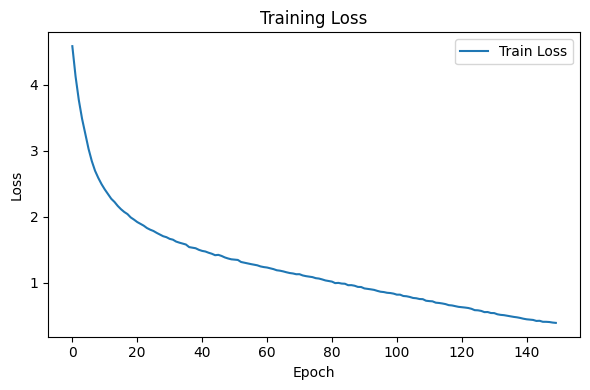

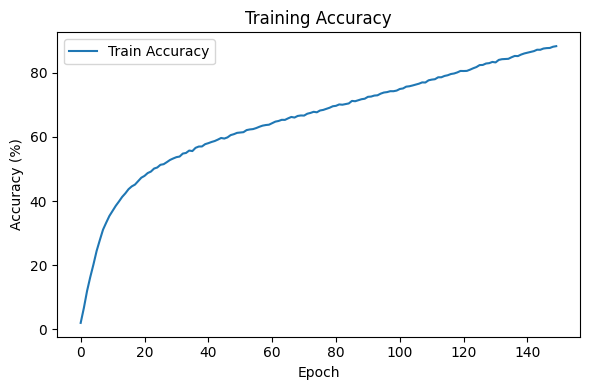

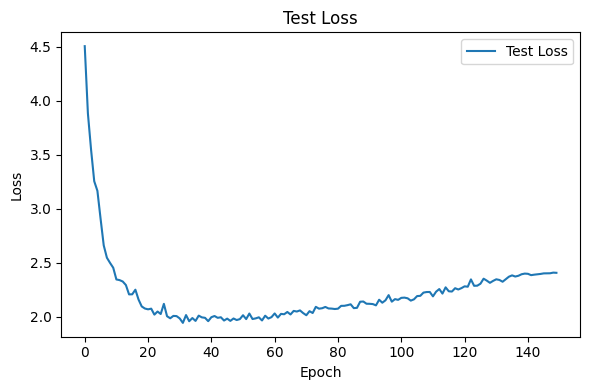

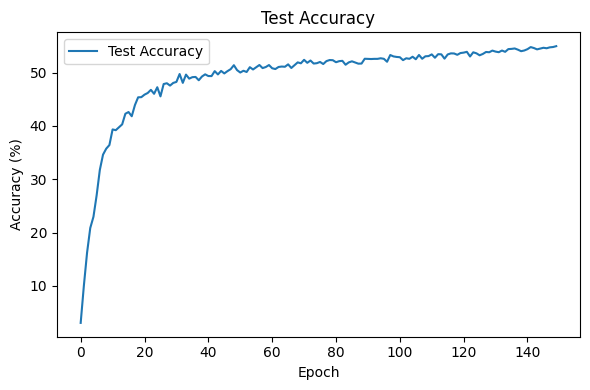

<Figure size 640x480 with 0 Axes>

In [3]:
%run large_batch_training.py --optimizer SGDM --batch-size 128 --weight-decay 4e-4